In [1]:
#import sys
#!{sys.executable} -m pip install PyAthena

fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from pyathena import connect
import pandas as pd
import numpy as np
import re

In [2]:
conn = connect(s3_staging_dir='s3://chembl-opentargets-43762-3/athena/',
               region_name='us-east-1')

In [3]:
#SELECT COUNT(*)
#FROM "open-targets-1911-dl"."association_data"
#WHERE LOWER(target.gene_info.name) LIKE '%tyrosine kinase%' limit 10000; 

In [4]:
chemblTKGeneIdsDF = pd.read_sql('SELECT DISTINCT target.id FROM "open_targets_1911_dl"."association_data" WHERE LOWER(target.gene_info.name) LIKE \'%tyrosine kinase%\'', conn)

In [5]:
chemblTKGeneIdsDF.describe

<bound method NDFrame.describe of                  id
0   ENSG00000167601
1   ENSG00000204580
2   ENSG00000074966
3   ENSG00000065361
4   ENSG00000148053
5   ENSG00000185359
6   ENSG00000122025
7   ENSG00000181409
8   ENSG00000007264
9   ENSG00000169071
10  ENSG00000066056
11  ENSG00000162733
12  ENSG00000254087
13  ENSG00000030304
14  ENSG00000164715
15  ENSG00000105976
16  ENSG00000178568
17  ENSG00000157404
18  ENSG00000112655
19  ENSG00000005700
20  ENSG00000153208
21  ENSG00000169398
22  ENSG00000010810
23  ENSG00000092445
24  ENSG00000142235
25  ENSG00000197122
26  ENSG00000102755
27  ENSG00000182511
28  ENSG00000140538
29  ENSG00000176105
30  ENSG00000062524
31  ENSG00000135605
32  ENSG00000174292
33  ENSG00000182866
34  ENSG00000143322
35  ENSG00000010671
36  ENSG00000037280
37  ENSG00000060140
38  ENSG00000061938
39  ENSG00000105397
40  ENSG00000171094
41  ENSG00000198400
42  ENSG00000047936
43  ENSG00000185483
44  ENSG00000090554
45  ENSG00000102010
46  ENSG00000120899
47  EN

In [6]:
print("value=", chemblTKGeneIdsDF.iloc[3, 0])

value= ENSG00000065361


In [7]:
testDF = pd.read_sql('SELECT * FROM "open_targets_1911_dl"."evidence_data" WHERE target.id=\''+chemblTKGeneIdsDF.iloc[3,0]+'\' AND unique_association_fields.datasource=\'chembl\'', conn)

In [8]:
testDF.size

3552

In [9]:
testEntry=testDF.iloc[0, :]

In [10]:
type(testEntry)

pandas.core.series.Series

In [11]:
testUAF=testEntry['unique_association_fields']

In [12]:
print(testUAF)

{disease_id=http://www.ebi.ac.uk/efo/EFO_0002892, url=https://clinicaltrials.gov/search?id=%22NCT01496313%22, target_id=http://identifiers.org/uniprot/P21860, datasource=chembl, chembl_molecule=http://identifiers.org/chembl.compound/CHEMBL24828, predictionmodel=null, disease_phenodigm_id=null, model_genetic_background=null, model_gene_id=null, score=null, model_description=null, disease_uri=null, disease_acronym=null, uniprot_release=null, target=null, publication_id=null, panel_diseasegroup=null, panel_id=null, disease_iri=null, panel_diseasesubgroup=null, original_disease_name=null, panel_name=null, panel_version=null, previous_code=null, pathway_id=null, efo_id=null, symbol=null, tumor_type_acronym=null, tumor_type=null, reaction_id=null, reaction_activity=null, mutations=null, original_disease_label=null, study_id=null, comparison_name=null, geneid=null, gene_set=null, pmid=null, gene_name=null, pubmed_refs=null, variant=null, study_name=null, pvalue_annotation=null, probe_id=null,

In [13]:
type(testUAF)

str

In [14]:
cmRegex=re.compile('chembl_molecule=http:\/\/identifiers\.org\/chembl\.compound\/([A-Z0-9]+),')

In [15]:
testMatch=cmRegex.search(testUAF)

In [16]:
testMatch

<_sre.SRE_Match object; span=(178, 245), match='chembl_molecule=http://identifiers.org/chembl.com>

In [17]:
testMatch.group(1)

'CHEMBL24828'

In [18]:
testEV=testEntry['evidence']

In [19]:
type(testEV)

str

In [20]:
print(testEV)

{target2drug={action_type=INHIBITOR, mechanism_of_action=Epidermal growth factor receptor inhibitor, urls=[{url=https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL24828, nice_name=ChEMBL molecule information}, {url=https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL2363049, nice_name=ChEMBL target information}, {url=http://dailymed.nlm.nih.gov/dailymed/lookup.cfm?setid=4dc7f0af-77fb-4eec-46b9-dd1c2dcb4525#section-13, nice_name=DailyMed}], provenance_type={literature=null, expert={status=true}, database={version=25, id=ChEMBL}}, is_associated=true, resource_score={type=probability, value=1}, evidence_codes=[http://purl.obolibrary.org/obo/ECO_0000205, http://identifiers.org/eco/target_drug, http://purl.obolibrary.org/obo/ECO_0000205, http://identifiers.org/eco/drug_disease], date_asserted=2015-01-14T00:00:00.000Z}, drug2clinic={status=Active, not recruiting, clinical_trial_phase={numeric_index=4, label=Phase IV}, urls=[{url=https://clinicaltrials.gov/search?id=%22NCT01496313%22, nice_nam

In [21]:
evRegex=re.compile('action_type=([^,]+),')

In [22]:
evMatch=evRegex.search(testEV)

In [23]:
evMatch

<_sre.SRE_Match object; span=(14, 36), match='action_type=INHIBITOR,'>

In [24]:
evMatch.group(1)

'INHIBITOR'

In [25]:
chemblTKInhibitorIds=[]
cti_uniq={}
geneId_chemblId_action=[]
gca_uniq={}

In [26]:
# This takes 20 minutes to run (but should blink if properly implemented with pandas)
for row_index, row in chemblTKGeneIdsDF.iterrows():
    print(row[0])
    geneDF = pd.read_sql('SELECT * FROM "open_targets_1911_dl"."evidence_data" WHERE target.id=\''+row[0]+'\' 
                         'AND unique_association_fields.datasource=\'chembl\'', conn)
    for ri2, r2 in geneDF.iterrows():
        uaf=r2['unique_association_fields']
        uaf_match=cmRegex.search(uaf)
        chemblId=uaf_match.group(1)
        evi=r2['evidence']
        ev_match=evRegex.search(evi)
        action=ev_match.group(1)
        if action=='INHIBITOR':
            gca_str=row[0]+' '+chemblId+' '+action
            if not gca_str in gca_uniq:
                print(gca_str)
                gca_uniq[gca_str]=1
                t = (row[0], chemblId, action)
                geneId_chemblId_action.append(t)
            if not chemblId in cti_uniq:
                cti_uniq[chemblId]=1
                chemblTKInhibitorIds.append(chemblId)

ENSG00000167601
ENSG00000167601 CHEMBL3301622 INHIBITOR
ENSG00000167601 CHEMBL2023349 INHIBITOR
ENSG00000167601 CHEMBL3545236 INHIBITOR
ENSG00000204580
ENSG00000074966
ENSG00000065361
ENSG00000065361 CHEMBL3353410 INHIBITOR
ENSG00000065361 CHEMBL24828 INHIBITOR
ENSG00000065361 CHEMBL2109406 INHIBITOR
ENSG00000065361 CHEMBL2110732 INHIBITOR
ENSG00000065361 CHEMBL180022 INHIBITOR
ENSG00000065361 CHEMBL3545154 INHIBITOR
ENSG00000065361 CHEMBL3137345 INHIBITOR
ENSG00000065361 CHEMBL3545071 INHIBITOR
ENSG00000065361 CHEMBL3707404 INHIBITOR
ENSG00000065361 CHEMBL2109401 INHIBITOR
ENSG00000065361 CHEMBL2109396 INHIBITOR
ENSG00000148053
ENSG00000148053 CHEMBL603469 INHIBITOR
ENSG00000148053 CHEMBL3889654 INHIBITOR
ENSG00000148053 CHEMBL3545298 INHIBITOR
ENSG00000148053 CHEMBL3545365 INHIBITOR
ENSG00000148053 CHEMBL3545179 INHIBITOR
ENSG00000148053 CHEMBL3545381 INHIBITOR
ENSG00000185359
ENSG00000122025
ENSG00000122025 CHEMBL535 INHIBITOR
ENSG00000122025 CHEMBL1336 INHIBITOR
ENSG00000122025 CHE

In [27]:
len(chemblTKInhibitorIds)

156

In [28]:
len(geneId_chemblId_action)

330

In [29]:
print(chemblTKInhibitorIds)

['CHEMBL3301622', 'CHEMBL2023349', 'CHEMBL3545236', 'CHEMBL3353410', 'CHEMBL24828', 'CHEMBL2109406', 'CHEMBL2110732', 'CHEMBL180022', 'CHEMBL3545154', 'CHEMBL3137345', 'CHEMBL3545071', 'CHEMBL3707404', 'CHEMBL2109401', 'CHEMBL2109396', 'CHEMBL603469', 'CHEMBL3889654', 'CHEMBL3545298', 'CHEMBL3545365', 'CHEMBL3545179', 'CHEMBL3545381', 'CHEMBL535', 'CHEMBL1336', 'CHEMBL608533', 'CHEMBL2105728', 'CHEMBL3545158', 'CHEMBL124660', 'CHEMBL576982', 'CHEMBL223360', 'CHEMBL52885', 'CHEMBL2035187', 'CHEMBL482968', 'CHEMBL522892', 'CHEMBL1944698', 'CHEMBL3545427', 'CHEMBL1230609', 'CHEMBL1908397', 'CHEMBL3545026', 'CHEMBL3545285', 'CHEMBL495727', 'CHEMBL1287853', 'CHEMBL3545281', 'CHEMBL1721885', 'CHEMBL2103851', 'CHEMBL3545358', 'CHEMBL2109328', 'CHEMBL1980391', 'CHEMBL1946170', 'CHEMBL1421', 'CHEMBL288441', 'CHEMBL206834', 'CHEMBL1980297', 'CHEMBL3545085', 'CHEMBL3545133', 'CHEMBL2105717', 'CHEMBL2103882', 'CHEMBL601719', 'CHEMBL3545212', 'CHEMBL3545307', 'CHEMBL3334567', 'CHEMBL3188267', 'CHEM

In [31]:
testActDF = pd.read_sql('SELECT DISTINCT act.activity_id, \
         pmd.molregno, \
         act.standard_value, \
         act.standard_units, \
         act.standard_type, \
         act.pchembl_value, \
         act.relation, \
         tgd.target_type, \
         tgd.pref_name \
FROM "chembl_25_dl"."chembl_25_public_molecule_dictionary" pmd, "chembl_25_dl"."chembl_25_public_activities" act, "chembl_25_dl"."chembl_25_public_assays" asy, "chembl_25_dl"."chembl_25_public_target_dictionary" tgd, "chembl_25_dl"."chembl_25_public_compound_properties" cp \
WHERE pmd.chembl_id=\'CHEMBL1946170\' \
        AND pmd.molregno = act.molregno \
        AND cp.molregno = act.molregno \
        AND act.standard_type = \'IC50\' \
        AND act.assay_id = asy.assay_id \
        AND asy.tid = tgd.tid \
        AND tgd.pref_name LIKE \'%kinase%\' \
        AND act.standard_value IS NOT NULL', conn)

In [32]:
testActDF

,activity_id,molregno,standard_value,standard_units,standard_type,pchembl_value,relation,target_type,pref_name
0,8023569,1277553,28.0,nM,IC50,7.55,=,SINGLE PROTEIN,Serine/threonine-protein kinase B-raf


In [104]:
t2 = pd.DataFrame()                                      

In [105]:
t2.append(testActDF)

,activity_id,molregno,standard_value,standard_units,standard_type,pchembl_value,relation,target_type,pref_name
0,8023569,1277553,28.0,nM,IC50,7.55,=,SINGLE PROTEIN,Serine/threonine-protein kinase B-raf


In [151]:
actDF = pd.DataFrame()

In [152]:
for id in chemblTKInhibitorIds:
    print(id)
    query = 'SELECT DISTINCT pmd.chembl_id, \
         pmd.molregno, \
         act.activity_id, \
         act.standard_value, \
         act.standard_units, \
         act.standard_type, \
         act.pchembl_value, \
         tgd.pref_name, \
         cp.mw_freebase, \
         cp.alogp, \
         CAST(cp.hba AS DOUBLE) as hba, \
         CAST(cp.hbd AS DOUBLE) as hbd, \
         cp.psa, \
         CAST(cp.rtb AS DOUBLE) as rtb, \
         cp.ro3_pass, \
         cp.acd_most_apka, \
         cp.acd_most_bpka, \
         cp.acd_logp, \
         cp.acd_logd, \
         cp.molecular_species, \
         cp.full_mwt, \
         CAST(cp.aromatic_rings AS DOUBLE) as aromatic_rings, \
         CAST(cp.heavy_atoms AS DOUBLE) as heavy_atoms, \
         cp.qed_weighted, \
         cp.mw_monoisotopic, \
         cp.full_molformula, \
         CAST(cp.hba_lipinski AS DOUBLE) as hba_lipinski, \
         CAST(cp.hbd_lipinski AS DOUBLE) as hbd_lipinski \
FROM "chembl_25_dl"."chembl_25_public_molecule_dictionary" pmd, \
"chembl_25_dl"."chembl_25_public_activities" act, \
"chembl_25_dl"."chembl_25_public_assays" asy, \
"chembl_25_dl"."chembl_25_public_target_dictionary" tgd, \
"chembl_25_dl"."chembl_25_public_compound_properties" cp \
WHERE pmd.chembl_id=\''+id+'\' \
        AND pmd.molregno = act.molregno \
        AND cp.molregno = act.molregno \
        AND act.standard_type = \'IC50\' \
        AND act.assay_id = asy.assay_id \
        AND asy.tid = tgd.tid \
        AND tgd.pref_name LIKE \'%kinase%\' \
        AND act.standard_value IS NOT NULL \
        AND act.relation = \'=\' \
        AND tgd.target_type = \'SINGLE PROTEIN\''
    tmpDF = pd.read_sql(query, conn)
    status = tmpDF.describe()
    actDF = actDF.append(tmpDF, sort=True)

CHEMBL3301622
CHEMBL2023349
CHEMBL3545236
CHEMBL3353410
CHEMBL24828
CHEMBL2109406
CHEMBL2110732
CHEMBL180022
CHEMBL3545154
CHEMBL3137345
CHEMBL3545071
CHEMBL3707404
CHEMBL2109401
CHEMBL2109396
CHEMBL603469
CHEMBL3889654
CHEMBL3545298
CHEMBL3545365
CHEMBL3545179
CHEMBL3545381
CHEMBL535
CHEMBL1336
CHEMBL608533
CHEMBL2105728
CHEMBL3545158
CHEMBL124660
CHEMBL576982
CHEMBL223360
CHEMBL52885
CHEMBL2035187
CHEMBL482968
CHEMBL522892
CHEMBL1944698
CHEMBL3545427
CHEMBL1230609
CHEMBL1908397
CHEMBL3545026
CHEMBL3545285
CHEMBL495727
CHEMBL1287853
CHEMBL3545281
CHEMBL1721885
CHEMBL2103851
CHEMBL3545358
CHEMBL2109328
CHEMBL1980391
CHEMBL1946170
CHEMBL1421
CHEMBL288441
CHEMBL206834
CHEMBL1980297
CHEMBL3545085
CHEMBL3545133
CHEMBL2105717
CHEMBL2103882
CHEMBL601719
CHEMBL3545212
CHEMBL3545307
CHEMBL3334567
CHEMBL3188267
CHEMBL3545325
CHEMBL3301578
CHEMBL496102
CHEMBL254760
CHEMBL3402762
CHEMBL2133806
CHEMBL2001019
CHEMBL2323775
CHEMBL3039525
CHEMBL3545050
CHEMBL3545053
CHEMBL460702
CHEMBL3545419
CHEMBL1

In [153]:
actDF

,acd_logd,acd_logp,acd_most_apka,acd_most_bpka,activity_id,alogp,aromatic_rings,chembl_id,full_molformula,full_mwt,...,mw_monoisotopic,pchembl_value,pref_name,psa,qed_weighted,ro3_pass,rtb,standard_type,standard_units,standard_value
0,0.19,1.15,None,8.14,17662997,2.70,2.0,CHEMBL3301622,C29H44N8O3,552.72,...,552.3536,8.72,Proto-oncogene tyrosine-protein kinase ROS,121.11,0.43,N,9.0,IC50,nM,1.9
1,0.19,1.15,None,8.14,17662961,2.70,2.0,CHEMBL3301622,C29H44N8O3,552.72,...,552.3536,8.82,ALK tyrosine kinase receptor,121.11,0.43,N,9.0,IC50,nM,1.5
2,0.19,1.15,None,8.14,17663015,2.70,2.0,CHEMBL3301622,C29H44N8O3,552.72,...,552.3536,9.39,Tyrosine-protein kinase receptor FLT3,121.11,0.43,N,9.0,IC50,nM,0.41
3,0.19,1.15,None,8.14,17662979,2.70,2.0,CHEMBL3301622,C29H44N8O3,552.72,...,552.3536,8.47,Tyrosine-protein kinase receptor RET,121.11,0.43,N,9.0,IC50,nM,3.4
0,2.81,5.49,None,10.34,10870027,4.88,4.0,CHEMBL2023349,C30H34N8,506.66,...,506.2906,7.85,Tyrosine-protein kinase receptor UFO,97.78,0.38,N,4.0,IC50,nM,14.0
0,2.50,4.00,None,8.92,14753656,5.00,3.0,CHEMBL24828,C22H24BrFN4O2,475.36,...,474.1067,6.82,Tyrosine-protein kinase ABL,59.51,0.54,N,6.0,IC50,nM,151.0
1,2.50,4.00,None,8.92,1175329,5.00,3.0,CHEMBL24828,C22H24BrFN4O2,475.36,...,474.1067,7.07,Tyrosine-protein kinase ABL,59.51,0.54,N,6.0,IC50,nM,86.0
2,2.50,4.00,None,8.92,15138131,5.00,3.0,CHEMBL24828,C22H24BrFN4O2,475.36,...,474.1067,6.99,Tyrosine-protein kinase receptor RET,59.51,0.54,N,6.0,IC50,nM,102.0
3,2.50,4.00,None,8.92,16498899,5.00,3.0,CHEMBL24828,C22H24BrFN4O2,475.36,...,474.1067,7.31,Tyrosine-protein kinase receptor RET,59.51,0.54,N,6.0,IC50,nM,49.0
4,2.50,4.00,None,8.92,1175340,5.00,3.0,CHEMBL24828,C22H24BrFN4O2,475.36,...,474.1067,5.60,Tyrosine-protein kinase TIE-2,59.51,0.54,N,6.0,IC50,nM,2500.0


In [109]:
# From the Chembl "compound_properties" table - there are HIVE problems with 2 columns (see below), but the other columns seem OK
# -- bad columns: num_ro5_violations, num_lipinski_ro5_violations, but these smallint columns can be selected independently
# SELECT molregno, mw_freebase, alogp, hba, hbd, psa, rtb, ro3_pass, acd_most_apka, acd_most_bpka, acd_logp, acd_logd, molecular_species, full_mwt, aromatic_rings, heavy_atoms, qed_weighted, mw_monoisotopic, full_molformula, hba_lipinski, hbd_lipinski FROM "chembl_25_dl"."chembl_25_public_compound_properties" limit 100;

In [122]:
import matplotlib.pyplot as plt

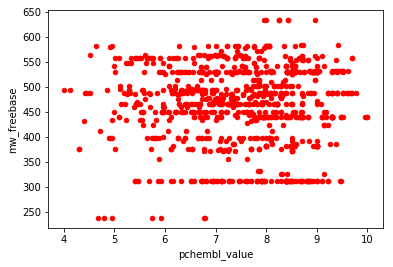

In [135]:
actDF.plot(kind='scatter',x='pchembl_value',y='mw_freebase',color='red')
plt.show()

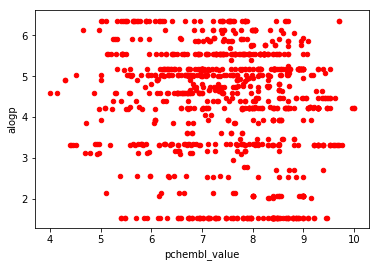

In [136]:
actDF.plot(kind='scatter',x='pchembl_value',y='alogp',color='red')
plt.show()

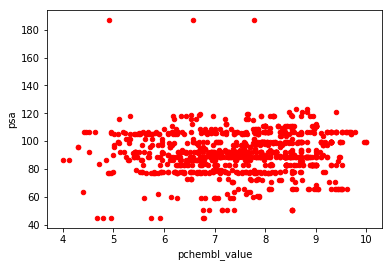

In [137]:
actDF.plot(kind='scatter',x='pchembl_value',y='psa',color='red')
plt.show()

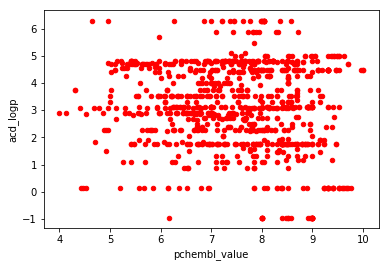

In [138]:
actDF.plot(kind='scatter',x='pchembl_value',y='acd_logp',color='red')
plt.show()

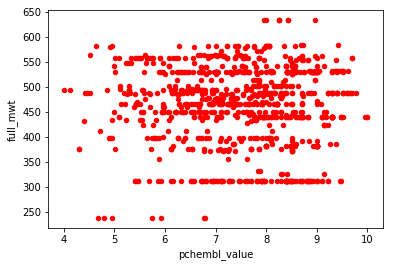

In [139]:
actDF.plot(kind='scatter',x='pchembl_value',y='full_mwt',color='red')
plt.show()

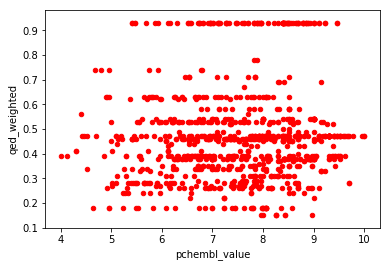

In [140]:
actDF.plot(kind='scatter',x='pchembl_value',y='qed_weighted',color='red')
plt.show()

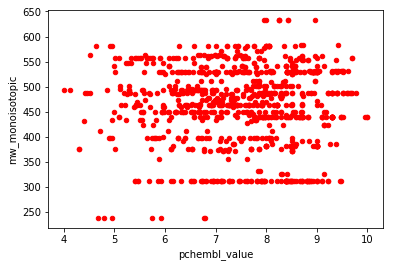

In [141]:
actDF.plot(kind='scatter',x='pchembl_value',y='mw_monoisotopic',color='red')
plt.show()

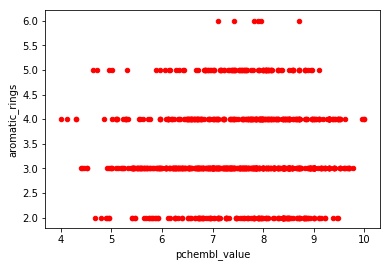

In [154]:
actDF.plot(kind='scatter',x='pchembl_value',y='aromatic_rings',color='red')
plt.show()

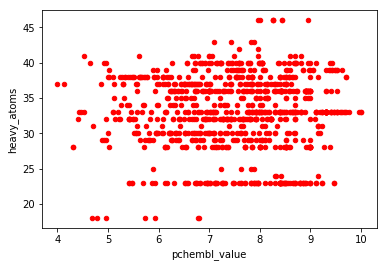

In [155]:
actDF.plot(kind='scatter',x='pchembl_value',y='heavy_atoms',color='red')
plt.show()

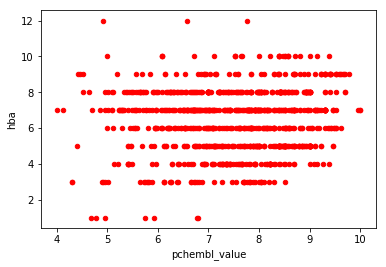

In [156]:
actDF.plot(kind='scatter',x='pchembl_value',y='hba',color='red')
plt.show()

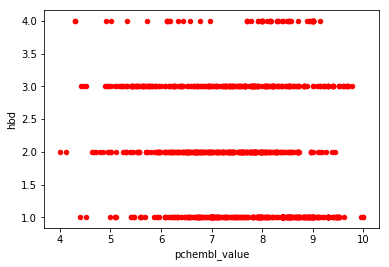

In [157]:
actDF.plot(kind='scatter',x='pchembl_value',y='hbd',color='red')
plt.show()

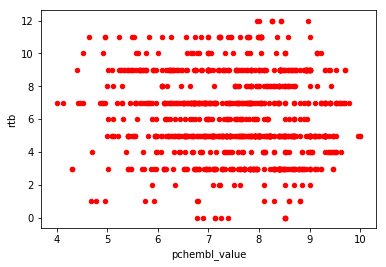

In [158]:
actDF.plot(kind='scatter',x='pchembl_value',y='rtb',color='red')
plt.show()

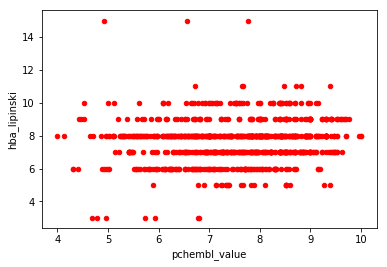

In [159]:
actDF.plot(kind='scatter',x='pchembl_value',y='hba_lipinski',color='red')
plt.show()

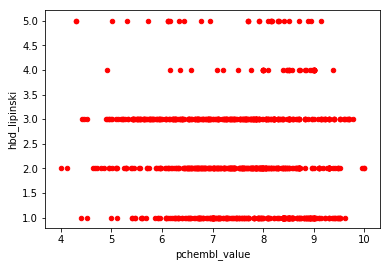

In [160]:
actDF.plot(kind='scatter',x='pchembl_value',y='hbd_lipinski',color='red')
plt.show()